In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import math
import random
import hashlib
from sklearn.cluster import KMeans

## 0. path and directory setting

In [2]:
data_dir = os.path.join('.', 'data')
order_file = os.path.join(data_dir, 'orders.csv')
order_prior_file = os.path.join(data_dir, "order_products__prior.csv")
product_file = os.path.join(data_dir, "products.csv")
# os.chdir(os.getcwd())
if not os.path.exists(os.path.join('.', 'fig')):
    os.makedirs(os.path.join('.', 'fig'))
if not os.path.exists(os.path.join('.', 'output_data')):
    os.makedirs(os.path.join('.', 'output_data'))
fig_dir = os.path.join('.', 'fig/')
output_data_dir = os.path.join('.', 'output_data/')

## 1. load data and analysis the data characteristics - construct the dataset

order_data(missing_part):
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


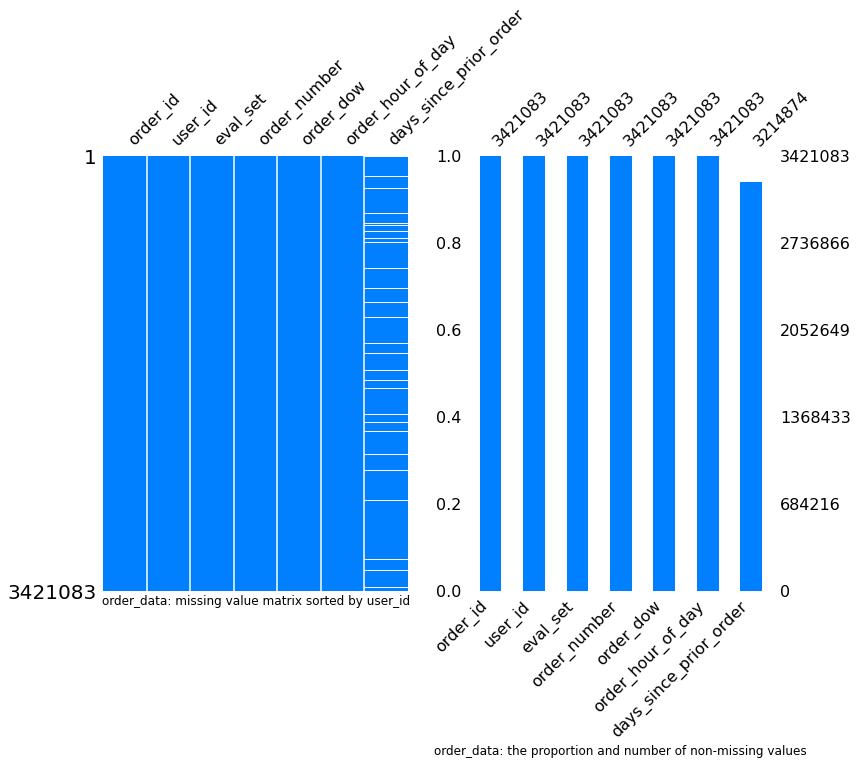

In [3]:
## 1.1 general analysis of the data

order_df = pd.read_csv(order_file)
order_df.loc[order_df["order_number"] == int(0), "order_number"] = np.nan
print('\033[1m'+"order_data(missing_part):\n"+'\033[0m', order_df.isna().sum(), sep='')

fig, axarr = plt.subplots(1, 2, figsize=(12, 8))
msno.matrix(order_df.sort_values("user_id"), ax=axarr[0], sparkline=False, color=([0, 128/255, 1]))
axarr[0].set_xlabel("order_data: missing value matrix sorted by user_id", fontsize=12)
msno.bar(order_df, ax=axarr[1], color=([0, 128/255, 1]))
axarr[1].set_xlabel("order_data: the proportion and number of non-missing values", fontsize=12)
fig.savefig(fig_dir + 'dataset_shape_and_missing_value.tif', format='tif', bbox_inches='tight')
# plt.show()

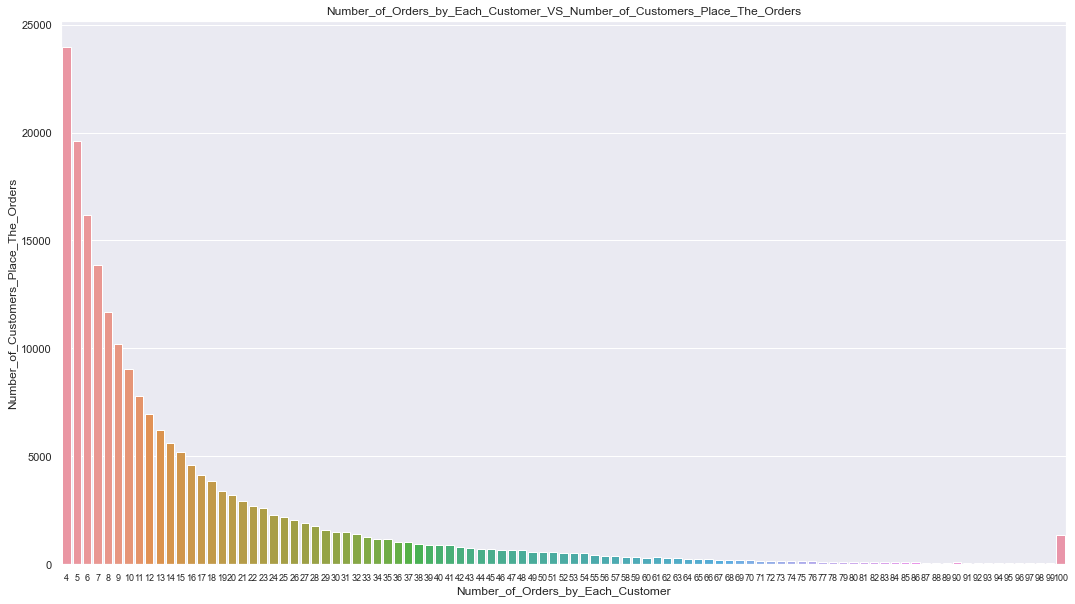

In [4]:
## 1.2 compare the number of orders and the number of customers

# the number of customers placed corresponding number of orders
order_per_cust_df = order_df.groupby("user_id")["order_number"].max().reset_index()
order_per_cust_df["order_number"] = order_per_cust_df["order_number"].astype(int)
# order_per_cust_df["order_number"].value_counts()

fig = plt.figure(figsize=(18,10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x = "order_number", data=order_per_cust_df)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
plt.title("Number_of_Orders_by_Each_Customer_VS_Number_of_Customers_Place_The_Orders")
plt.xlabel("Number_of_Orders_by_Each_Customer")
plt.ylabel("Number_of_Customers_Place_The_Orders")
fig.savefig(fig_dir + 'Orders_vs_Users.tif', format='tif')
# plt.show()

In [5]:
## 1.3 merge data together to get the ideal dataset for analysis
# (1)
print("order_subdataset")
display(order_df.head())
# (2)
print("order_products_prior_subdataset")
order_prior_df = pd.read_csv(order_prior_file)
display(order_prior_df.head())
# (3)
# change the type of product_name as str
print("products_subdataset")
product_df = pd.read_csv(product_file, index_col="product_id", dtype={'product_name': pd.StringDtype()})
display(product_df.head())

order_subdataset


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1.0,2,8,NaN
1,2398795,1,prior,2.0,3,7,15.0
2,473747,1,prior,3.0,3,12,21.0
3,2254736,1,prior,4.0,4,7,29.0
4,431534,1,prior,5.0,4,15,28.0


order_products_prior_subdataset


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


products_subdataset


,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [6]:
# 1.3.1
# extract product being reordered from order_prior_df
prior_order_product = order_prior_df[order_prior_df["reordered"]==1] # reordered == 1 -> True; 0-> False

# 1.3.2
# merge order_subdataset and order_prior_subdataset together based on the order_id 
# (add product_id into the dataset)
user_order_prior = pd.merge(prior_order_product, order_df, on="order_id", how="left")

# 1.3.3
# futher add product_info into user_order_prior from products_subdataset based on the product_id
user_order_prior = pd.merge(user_order_prior, product_df, on="product_id", how="left")
# user_order_prior maps info such as product_id and product_name into coresponding orders(order_id) and users(user_id)
user_product_prior = user_order_prior[["user_id", "product_name"]]
# double check if the product_name is str, since we need to merge them based on the user_id
user_product_prior["product_name"].dtypes
user_product_prior.head()

# 1.3.4 Merge prior product based on user_id (duplicates) to get the ideal dataset for analysis
user_product_prior = user_product_prior.groupby('user_id').agg({ 'product_name': ', '.join}).reset_index()
user_product_prior = user_product_prior.rename(columns={"user_id": "user_id", "product_name": "product_prior_set"})
user_product_prior.head()

,user_id,product_prior_set
0,1,"Soda, Original Beef Jerky, Pistachios, Organic..."
1,2,"Chipotle Beef & Pork Realstick, Chipotle Beef ..."
2,3,"Organic Baby Spinach, Unsweetened Chocolate Al..."
3,4,Enchilada Black Bean Vegetable
4,5,"Plain Whole Milk Yogurt, Whole Vitamin D Milk,..."


## 2 TF-IDF product_prior_set

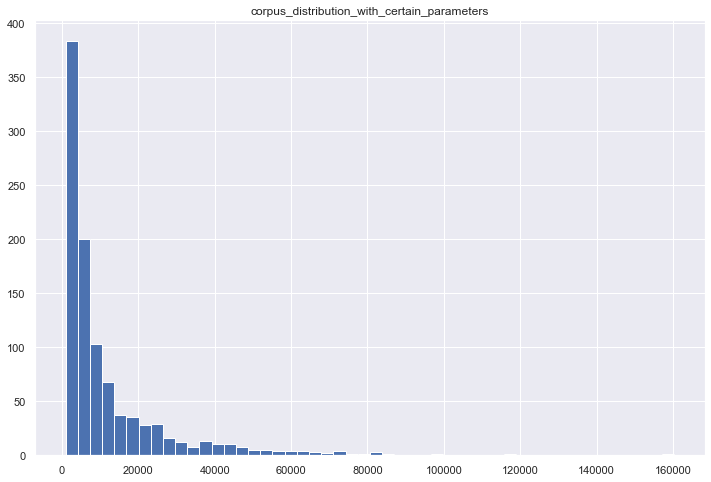

In [7]:
tfidf_up = TfidfVectorizer(input='content', encoding='iso-8859-1', min_df=5, max_features=1000, sublinear_tf=True, 
                           decode_error='ignore', analyzer='word',
                           ngram_range=(1,1), stop_words='english')
# 1000 features generated from the reorder product sentences of each users
tfidf_up_model = tfidf_up.fit_transform(user_product_prior["product_prior_set"])
tfidf_up_df = pd.DataFrame(tfidf_up_model.toarray(), columns=tfidf_up.get_feature_names(), 
                           index = user_product_prior["user_id"])
#tfidf_up_df.head()
# tfidf_up_df.to_csv(output_data_dir+"1000features_from_tfidf.csv")
# corpus distribution with certain parameters such as min_df, max_features
fig = plt.figure(figsize=(12,8))
tfidf_hist = tfidf_up_df[tfidf_up_df>0].count(axis=0)
plt.hist(tfidf_hist, bins=50)
plt.title("corpus_distribution_with_certain_parameters")
fig.savefig(fig_dir + 'corpus_distribution_with_certain_parameters.tif', format='tif')
# plt.show()

## 3 Use the tfidf-feature dataset to do the feature compression and cosine-LSH

In [8]:
def getMd5Hash(band):
    hashobj=hashlib.md5()
    hashobj.update(band.encode())
    hashValue = hashobj.hexdigest()
    return hashValue

def cos_lsh(feature_matrix, r, b):
    sig_matrix_size = r*b
    id_num = feature_matrix.shape[0]
    feature_num = feature_matrix.shape[1]    
    """
    get the random vector matrix, and further generate the signature matrix
    """
    random_vector_matrix = np.random.randn(feature_num, sig_matrix_size) 
    compression = np.dot(feature_matrix, random_vector_matrix)
    sig_matrix = np.where(compression>0, 1, 0).T
#     return sig_matrix
    """
    1. parameters:
    hashbucket: key: hashvalue; value: possible candidate
    each hash function start at 0, r, 2r...; end at r, 2r, 3r ...; the same hash function use for the same band
    b_index: band index (start at 1)
    
    2. logic:
    while signature_matrix rows number >= end:
        for each column:
            get the each id's sigature vector piece, make it into string and combine with band_index
            make such combination into a md5 hash value -> as a label for such vector piece
            if such hash value (label) not in the bucket:
                add the column to the corresponding key (label)
            elif hash value in the bucket, but column not in the bucket of the corresponding hash value
                add the column to it
        till signature_matrix rows number < end
    return hash bucket
    """
    hashBuckets={}
    start=0
    end=r
    b_index = 1    
    while sig_matrix.shape[0] >= end:
        # col_num is the range
        # 
        for col_num in range(sig_matrix.shape[1]):
            band = str(sig_matrix[start:end, col_num])+str(b_index)
            hashValue=getMd5Hash(band)
            if hashValue not in hashBuckets:
                hashBuckets[hashValue] = [feature_matrix.index[col_num]]
            elif feature_matrix.index[col_num] not in hashBuckets[hashValue]:
                hashBuckets[hashValue].append(feature_matrix.index[col_num])
        start += r
        end += r
        b_index += 1
    return hashBuckets

cos_bucket = cos_lsh(tfidf_up_df, 5, 5)  # r=5, b=5
## print(len(cos_bucket))

res=pd.DataFrame(cos_bucket.items(), columns = ["hash_values", "similar_user_sets"])
display(res.head())
res.to_csv(output_data_dir+"LSH_result.csv")

# from itertools import combinations
# cand_pairs = set()
# for v in cos_bucket.values():
#     cand_pairs.update(set(combinations(v, 2)))
# cand_pairs 
##user_product_ori = user_product_prior
##user_product_ori = user_product_ori.set_index("user_id")
##user_product_ori[user_product_ori.index==1].iloc[0, 0]
##user_product_ori[user_product_ori.index==85].iloc[0, 0]

,hash_values,similar_user_sets
0,253d52d0328ec38206a9aacd1edfd193,"[1, 16, 32, 57, 103, 128, 146, 147, 154, 157, ..."
1,db6b4731e99d8488dcf4207e32a67a5b,"[2, 104, 140, 156, 377, 426, 467, 500, 566, 56..."
2,66c8e325df507ecc1ec3591874361b39,"[3, 81, 112, 131, 179, 222, 257, 259, 260, 320..."
3,7f50da64a121ded64f1ed4075511bc1f,"[4, 7, 10, 15, 51, 69, 70, 137, 138, 202, 232,..."
4,eb8e82a9d88595b4b83c903dcf6e52e9,"[5, 9, 21, 27, 43, 59, 62, 67, 77, 79, 82, 89,..."


In [22]:
user_product_ori = user_product_prior
user_product_ori = user_product_ori.set_index("user_id")
user_product_ori[user_product_ori.index==1].iloc[0, 0]

'Soda, Original Beef Jerky, Pistachios, Organic String Cheese, Bag of Organic Bananas, Soda, Original Beef Jerky, Pistachios, Soda, Pistachios, Original Beef Jerky, Organic String Cheese, Cinnamon Toast Crunch, Soda, Original Beef Jerky, Pistachios, Organic String Cheese, XL Pick-A-Size Paper Towel Rolls, Organic Half & Half, Zero Calorie Cola, Organic String Cheese, Soda, Pistachios, Original Beef Jerky, Soda, Original Beef Jerky, Aged White Cheddar Popcorn, Soda, Zero Calorie Cola, Organic String Cheese, Pistachios, Cinnamon Toast Crunch, Original Beef Jerky, Original Beef Jerky, Soda, Pistachios, Organic String Cheese, Soda, Original Beef Jerky, Pistachios, Organic String Cheese'

In [23]:
user_product_ori[user_product_ori.index==16].iloc[0, 0]

'Organic Baby Spinach, Organic Tomato Cluster, Organic Thompson Seedless Raisins, Organic Small Bunch Celery, Carrots, Organic Baby Spinach, Michigan Organic Kale, Organic Tomato Cluster, Organic Thompson Seedless Raisins, Frozen Organic Wild Blueberries, Organic Strawberries, Banana, Organic Baby Spinach, Organic Tomato Cluster, Organic Thompson Seedless Raisins, Frozen Organic Wild Blueberries, Sliced Baby Bella Mushrooms, Organic Salted Butter, Globe Eggplant, Organic Baby Spinach, Mint, Organic Strawberries, Banana, Organic Thompson Seedless Raisins'

## 4 KMeans clustering

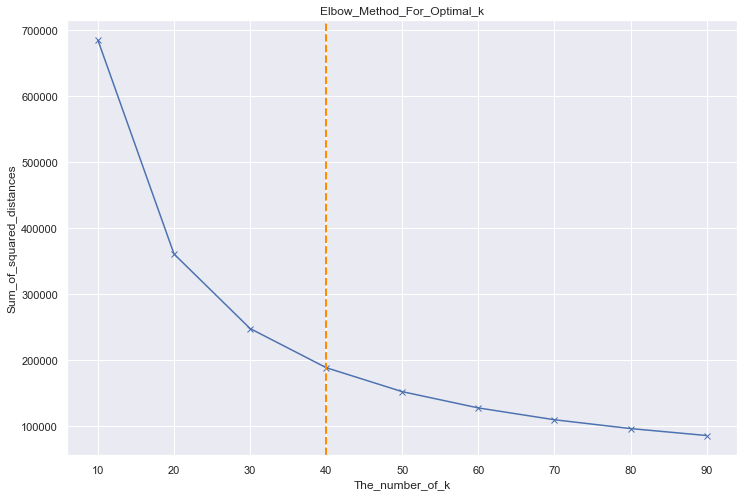

In [11]:
## 4.1 add additonal 5 features based on some user beheavor into the 1000 tfidf features
user_avg = user_order_prior.groupby('user_id')[['order_dow','order_hour_of_day', 'days_since_prior_order']].agg(np.nanmean)
order_num = user_order_prior.groupby("user_id").order_id.nunique()
product_num = user_order_prior.groupby("user_id")["product_id"].agg('count')
user_avg["order_num"] = order_num
user_avg["product_num"] = product_num
# user_avg
user_features = pd.merge(user_avg, tfidf_up_df, how='inner', on="user_id")
# user_features

## 4.2 standardize the 1005 features by StandardScaler
scaler = StandardScaler()
scaler.fit(user_features)
standard_user_features_data = scaler.transform(user_features)
standard_user_features = pd.DataFrame(standard_user_features_data, index = user_features.index, columns = user_features.columns)
standard_user_features

## 4.3 decomposite the 1005 features into two principle components by PCA method
standard_user_features_pca = PCA(2).fit(standard_user_features.values)
reduced_standard_user_features = PCA(2).fit_transform(standard_user_features.values)
standard_user_features_df = pd.DataFrame(reduced_standard_user_features, index = standard_user_features.index, columns = ["PC1", "PC2"])
standard_user_features_df.head()

## 4.4 find the optimal k value for KMeans study by Elbow Method
Sum_of_squared_distances = []
K = range(10, 100, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(standard_user_features_df)
    Sum_of_squared_distances.append(km.inertia_)

fig = plt.figure(figsize=(12,8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('The_number_of_k')
plt.axvline(40, color='darkorange', linestyle='dashed', linewidth=2)
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow_Method_For_Optimal_k')
fig.savefig(fig_dir + 'Elbow_Method_For_Optimal_k.tif', format='tif')
# plt.show()

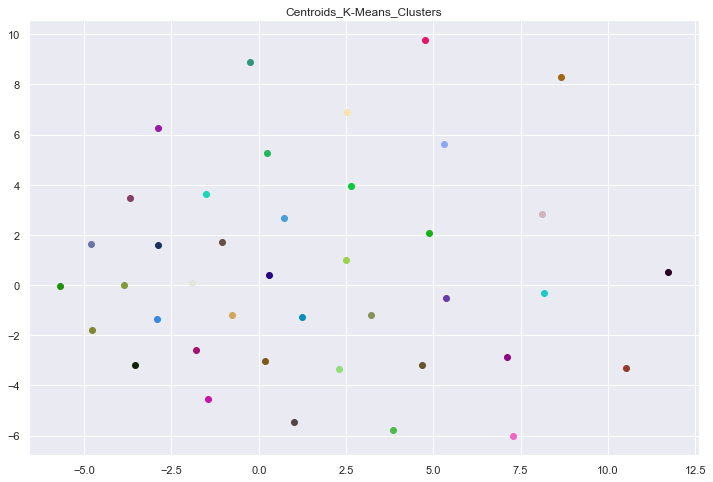

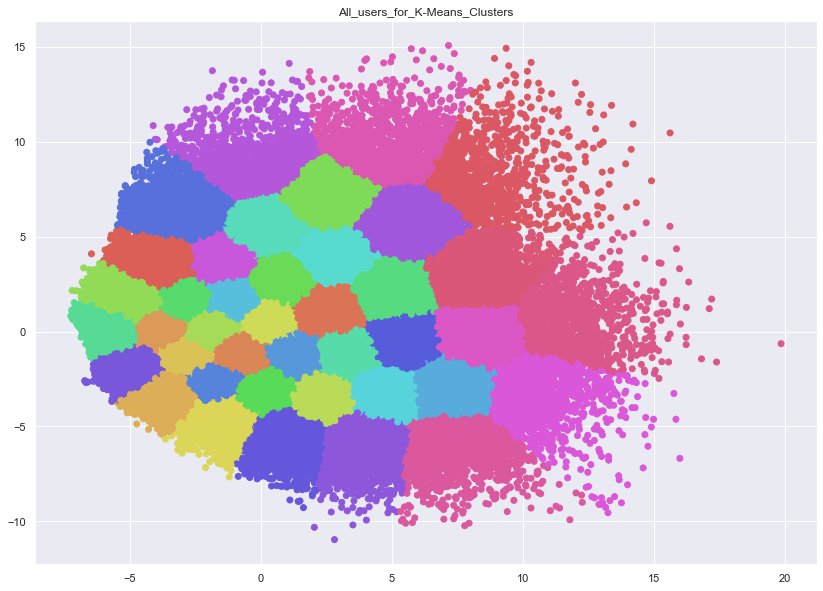

In [12]:
## 4.5 use sklearn KMeans method to create the user cluster model

### 4.5.1 cluster centroids fig
kmeans = KMeans(n_clusters=40).fit(standard_user_features_df)
centroids = kmeans.cluster_centers_
fig = plt.figure(figsize=(12,8))
x_coordinates = centroids[:, 0]
y_coordinates = centroids[:, 1]
for x, y in zip(x_coordinates, y_coordinates):
    rgb = (random.random(), random.random(), random.random())
    plt.scatter(x, y, c=[rgb])
plt.title("Centroids_K-Means_Clusters")
fig.savefig(fig_dir + 'Centroids_K-Means_Clusters.tif', format='tif')
# plt.show()

### 4.5.2 all user cluster fig
kmeans_res = standard_user_features_df
kmeans_res["cluster_id"] = kmeans.labels_
kmeans_res.head()
fig = plt.figure(figsize=(14,10))
# Unique category labels for clusters_id
color_labels = kmeans_res['cluster_id'].unique()
# prepare the color_palette
rgb_values = sns.color_palette("hls", 40)
# Map the label of clusters_id to RGB
color_map = dict(zip(color_labels, rgb_values))
# plot
plt.scatter(kmeans_res.iloc[:, 0], kmeans_res.iloc[:, 1], c=kmeans_res['cluster_id'].map(color_map))
plt.title("All_users_for_K-Means_Clusters")
fig.savefig(fig_dir + 'All_users_for_K-Means_Clusters.tif', format='tif')
# plt.show()

In [13]:
### 4.5.3 analyze the cluster results
cluster_order_info = pd.merge(kmeans_res, user_order_prior, how='left', on='user_id')
cluster_order_info.head()
cluster_product = cluster_order_info[['user_id','cluster_id','product_name']]
cluster_product

,user_id,cluster_id,product_name
0,1,25,Soda
1,1,25,Original Beef Jerky
2,1,25,Pistachios
3,1,25,Organic String Cheese
4,1,25,Bag of Organic Bananas
...,...,...,...
19126531,206209,18,Banana
19126532,206209,18,Calcium Enriched 100% Lactose Free Fat Free Milk
19126533,206209,18,Large Organic Omega3 Brown Eggs
19126534,206209,18,Tomato Paste


In [14]:
## the frequency of products in each cluster
cluster_count = cluster_product.groupby(['cluster_id','product_name']).agg('count')
## top10 products in each cluster
top_products = cluster_count['user_id'].groupby(level=0, group_keys=False).nlargest(10).reset_index()
# top_products
all_clusters_top_products =top_products.pivot(index='cluster_id', columns='product_name', values='user_id').fillna(0)
all_clusters_top_products_percent = all_clusters_top_products.div(all_clusters_top_products.sum(axis=0), axis=1)

all_clusters_top_products.to_csv(output_data_dir+"top10_products_in_each_cluster.csv")
all_clusters_top_products_percent.to_csv(output_data_dir+"the percent_of_each_cluster_top10_products_across_all_clusters.csv")

In [15]:
all_clusters_top_products

product_name,0% Greek Strained Yogurt,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Baby Cucumbers,Bag of Organic Bananas,Banana,Beer,Blueberries,Clementines,...,Sparkling Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Sweet Kale Salad Mix,Trail Mix,Ultra Soft Facial Tissues,White Giant Paper Towel Rolls,Whole Milk,Zero Calorie Cola
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,673.0,0.0,499.0,0.0,644.0,...,632.0,0.0,922.0,0.0,0.0,767.0,0.0,0.0,0.0,1512.0
1,0.0,0.0,0.0,0.0,0.0,17168.0,19680.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1670.0,2578.0,0.0,0.0,1765.0,9111.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2098.0,0.0,0.0,0.0,0.0,1366.0,0.0
3,0.0,0.0,0.0,0.0,0.0,7337.0,8040.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3333.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,6912.0,0.0,23996.0,24437.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1581.0,1516.0,0.0,0.0,3764.0,9719.0,0.0,0.0,1783.0,...,0.0,1535.0,0.0,2488.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,11222.0,18471.0,0.0,0.0,0.0,...,0.0,4441.0,0.0,4158.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,969.0,4263.0,1074.0,0.0,0.0,1009.0,...,0.0,0.0,0.0,1474.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,10796.0,13851.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3397.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
all_clusters_top_products_percent

product_name,0% Greek Strained Yogurt,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Baby Cucumbers,Bag of Organic Bananas,Banana,Beer,Blueberries,Clementines,...,Sparkling Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Sweet Kale Salad Mix,Trail Mix,Ultra Soft Facial Tissues,White Giant Paper Towel Rolls,Whole Milk,Zero Calorie Cola
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.002137,0.000000,1.0,0.000000,0.044521,...,0.460306,0.000000,0.182430,0.000000,0.0,0.195963,0.0,0.000000,0.000000,0.556291
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.054520,0.049431,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.000000,0.121836,0.143541,0.000000,0.00000,0.005605,0.022884,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.035020,0.0,0.000000,0.0,0.000000,0.383924,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.023300,0.020194,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.055634,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.513293,0.00000,0.076204,0.061379,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
5,0.000000,0.115343,0.084410,0.000000,0.00000,0.011953,0.024411,0.0,0.000000,0.123263,...,0.000000,0.095657,0.000000,0.041530,0.0,0.000000,0.0,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.00000,0.035638,0.046394,0.0,0.000000,0.000000,...,0.000000,0.276750,0.000000,0.069405,0.0,0.000000,0.0,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.38729,0.013538,0.002698,0.0,0.000000,0.069755,...,0.000000,0.000000,0.000000,0.024604,0.0,0.000000,0.0,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.034285,0.034790,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.056703,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [17]:
def plot_cluster_top_prod(cluster_l, cluster_right):
    fig, ax = plt.subplots(1,figsize=(12,8),sharey=True)

    group = []
    for i in range(cluster_l, cluster_right+1):
        group.append(i)
    ax.plot(all_clusters_top_products_percent.loc[group].transpose())
    ax.legend(all_clusters_top_products_percent.transpose().columns[cluster_l: cluster_right+1],
               title="Cluster_ID",loc='upper left',prop={'size': 12})
    ax.set_title('Percent_of_Products_from_Cluster{}_to_Cluster{}'.format(cluster_l, cluster_right),size=20)
    
    plt.sca(ax)
    plt.xticks(rotation=90, size=12)
    plt.subplots_adjust(wspace=0, hspace=0.7)
    fig.savefig(fig_dir + 'Percent_of_Products_from_Cluster{}_to_Cluster{}.tif'.format(cluster_l, cluster_right), format='tif', bbox_inches='tight')

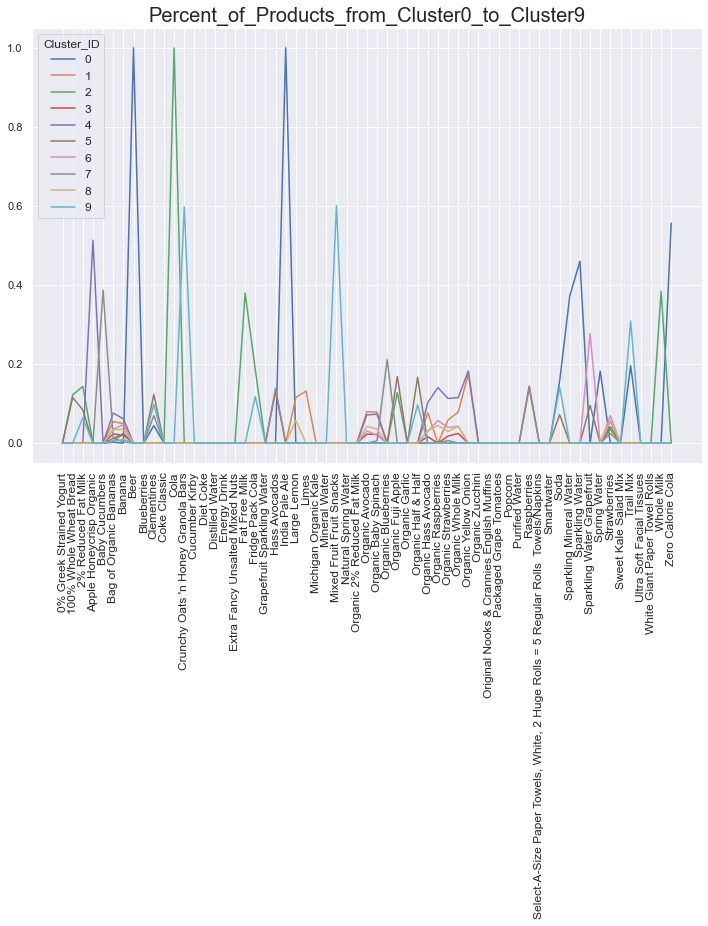

In [18]:
plot_cluster_top_prod(0, 9)

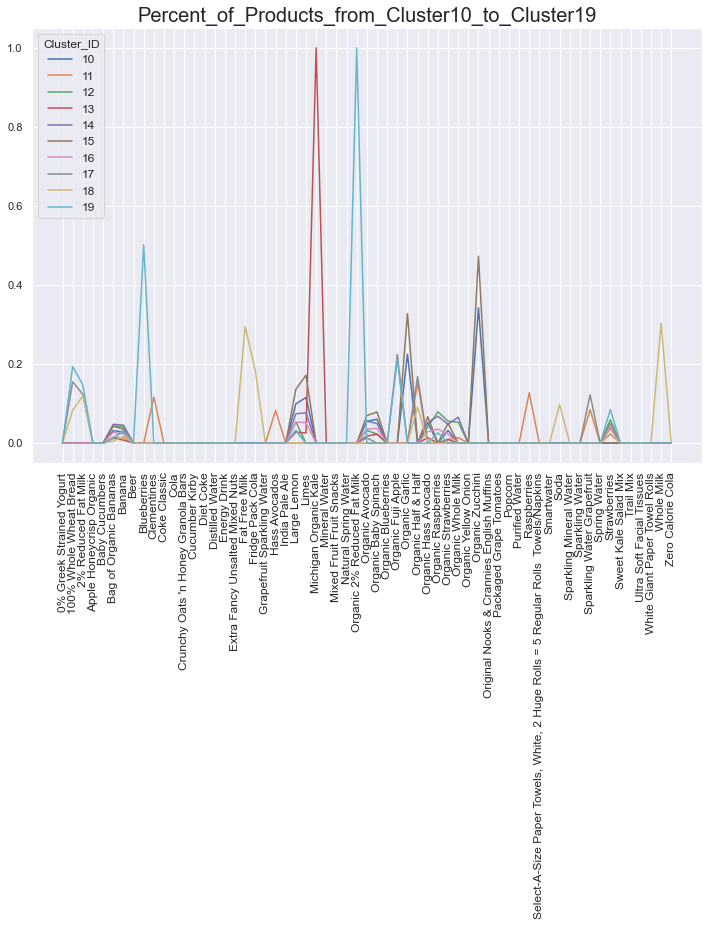

In [19]:
plot_cluster_top_prod(10, 19)

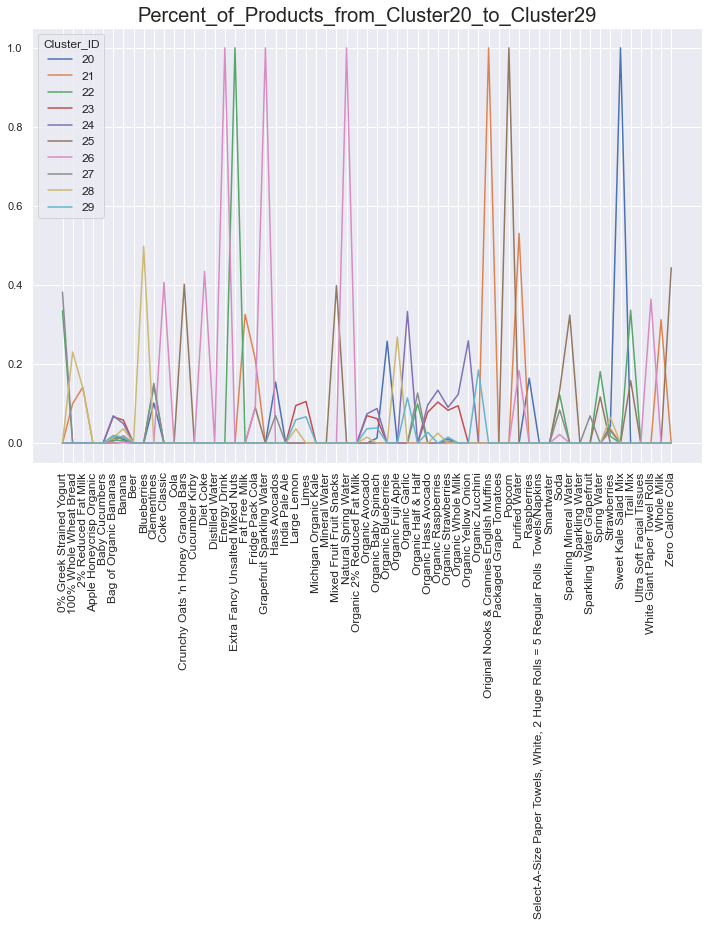

In [20]:
plot_cluster_top_prod(20, 29)

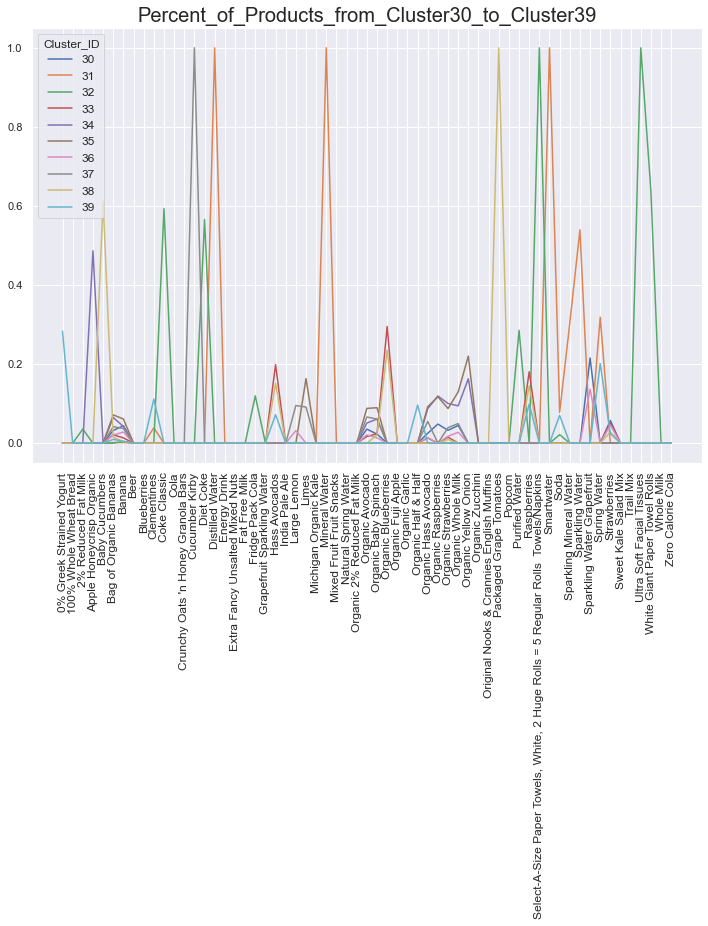

In [21]:
plot_cluster_top_prod(30, 39)